# Gradient-free Global Maximum Likelihood Finding: Neural Networks

Neural network training is typically done with maximum likelihood estimation. Given the number of parameter invariances, and symmetries in neural network architectures, this often introduces a large number of local minima, making global optimisation very difficult.

JAXNS uses slice sampling as a gradient-free way to sample from hard-likelihood constraints, starting from small likelihoods and strictly increasing towards a maximum likelihood. This actually means that JAXNS is performing global maximisation of the likelihood. The prior can be seen as a measure which guides where JAXNS looks first. An attractive idea is to think about the prior as a guide for efficient global maximisation with JAXNS, but that's for another tutorial ;).

## Overview

In this tutorial we'll cover:
1. How to build a JAXNS model of a neural network using [Haiku](https://github.com/deepmind/dm-haiku)
2. How to do global likelihood maximisation with JAXNS

In [1]:
try:
    import haiku as hk
except ImportError:
    raise ImportError("You must `pip install dm-haiku` first.")

try:
    from sklearn.metrics import roc_curve
except:
    raise ImportError("You must `pip install scikit-learn`")

from jax import numpy as jnp, random, vmap
import jax
from jax.flatten_util import ravel_pytree

from jaxns.prior_transforms import UniformPrior, PriorChain
from jaxns import GlobalOptimiser
from jax.scipy.optimize import minimize
from itertools import product
import pylab as plt

# for parallel sampling
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"



In [2]:
# Generate data

def xor_reduce(x):
    """
    Computes the XOR reduction on a sequence of bits.

    Examples:
        100 -> xor(xor(1,0),0) = 1
        001 -> xor(xor(0,0),1) = 1
        110 -> xor(xor(1,1),0) = 0
        011 -> xor(xor(0,1),1) = 0

    Args:
        x: boolean vector of bits.

    Returns:
        bool, scalar
    """
    output = x[0]
    for i in range(1, x.shape[-1]):
        output = jnp.logical_xor(output, x[i])
    return output


num_variables = 9
options = [True, False]
x = jnp.asarray(list(product(options, repeat=num_variables)))#N,2
y = vmap(xor_reduce)(x)[:, None]#N, 1
x = x.astype(jnp.float32)
print("Data:")

for input, output in zip(x,y):
    print(f"{input} -> {output}")


INFO[2022-06-01 22:46:25,736]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-06-01 22:46:25,737]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-06-01 22:46:25,738]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-06-01 22:46:25,738]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Data:
[1. 1. 1. 1. 1. 1. 1. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 1. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 1. 1. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 1. 1. 0. 0.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 1. 1.] -> [False]
[1. 1. 1. 1. 1. 1. 0. 1. 0.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 0. 1.] -> [ True]
[1. 1. 1. 1. 1. 1. 0. 0. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 1. 1. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 1. 1. 0.] -> [ True]
[1. 1. 1. 1. 1. 0. 1. 0. 1.] -> [ True]
[1. 1. 1. 1. 1. 0. 1. 0. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 1. 1.] -> [ True]
[1. 1. 1. 1. 1. 0. 0. 1. 0.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 0. 1.] -> [False]
[1. 1. 1. 1. 1. 0. 0. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 1. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 1. 1. 0.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 0. 1.] -> [ True]
[1. 1. 1. 1. 0. 1. 1. 0. 0.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 1. 1.] -> [ True]
[1. 1. 1. 1. 0. 1. 0. 1. 0.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 0. 1.] -> [False]
[1. 1. 1. 1. 0. 1. 0. 0. 0.] -> [ True]
[1. 1. 1. 1. 0. 0. 1. 1. 1.] -> [ 

In [3]:
# Define the likelihood, using Haiku as our framework for neural networks

def model(x, is_training=False):
    mlp1 = hk.Sequential([hk.Linear(3),
                         jax.nn.sigmoid,
                          hk.Linear(1)])

    return mlp1(x)

model = hk.without_apply_rng(hk.transform(model))
# We must call the model once to get the params shape and type as a big pytree
# We then use ravel_pytree to flatten and get the unflatten function.
init_params = model.init(random.PRNGKey(2345), x)
init_params_flat, unravel_func = ravel_pytree(init_params)
n_dims = init_params_flat.size
print("Number of parameters:", n_dims)

def softplus(x):
    return jnp.log1p(jnp.exp(x))

def log_likelihood(params):
    """
    log(P(y|p))
    p = exp(logits)/1 - exp(logits)
    = log(p) * y + log(1-p) * (1-y)
    = logits * y1 - log(exp(-logits)/(exp(-logits) - 1)) * y0
    """
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    log_prob0, log_prob1 = -softplus(logits), -softplus(-logits)
    #log(p) * y + log(1-p) * (1-y)
    log_prob = jnp.mean(jnp.where(y, log_prob1, log_prob0))
    return jnp.asarray(log_prob, jnp.float64)


Number of parameters: 34


In [4]:
# Let us compare the results of nested sampling to optimisation done with BFGS
num_random_init = 100
init_keys = random.split(random.PRNGKey(42), num_random_init)
params_bfgs = vmap(lambda key: minimize(lambda p: -log_likelihood(p),
                   random.normal(key, shape=(n_dims,)),
                   method='BFGS').x)(init_keys)
log_L_bfgs = vmap(log_likelihood)(params_bfgs)
idx_max = jnp.argmax(log_L_bfgs)
log_L_bfgs_max = log_L_bfgs[idx_max]
params_bfgs_max = params_bfgs[idx_max]
print(f"BFGS maximum likelihood solution of {num_random_init} tries: log(L) = {log_L_bfgs_max}")

/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


BFGS maximum likelihood solution of 100 tries: log(L) = -0.6931270360946655


In [5]:
# Build the model

with PriorChain() as prior_chain:
    # we'll effectively place no prior on the parameters, other than requiring them to be within [-10,10]
    UniformPrior('params', -10*jnp.ones(n_dims), 10*jnp.ones(n_dims))

prior_chain.build()
# Let's test the model with a small sanity check.
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")
INFO[2022-06-01 22:46:45,530]: Log-likelihood: -1.2018872499465942
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_us

In [6]:
# We'll do some strange things here.
# num_slices -> low: We'll make the sampler do very few slices. This will lead to large correlation between samples, and poor estimate of the evidence.
# This is alright, because we'll be looking for the maximum likelihood solution.
go = GlobalOptimiser(loglikelihood=log_likelihood,
                     prior_chain=prior_chain, 
                     num_parallel_samplers=4,
                   samples_per_step=prior_chain.U_ndims*30)

results = go(random.PRNGKey(42))

WARNING[2022-06-01 22:46:45,615]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/dispatch.py:315: UserWarning: The jitted function while includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


In [7]:
# The maximum likelihood solution from nested sampling
params_max = results.sample_L_max['params']
log_L_max = results.log_L_max
print("log L_max(L)", log_L_max)
go.summary(results)

log L_max(L) -0.39425564
--------
Termination Conditions:
Small enough likelihood change with patience
--------
# likelihood evals: 13522306
# samples: 149940
# likelihood evals / sample: 90.2
--------
Maximum logL=-0.39
--------
params[#]: max(L) est.
params[0]: 3.8
params[1]: -5.04
params[2]: 4.1
params[3]: -9.7
params[4]: -4.3
params[5]: 9.9
params[6]: 9.9
params[7]: 4.3
params[8]: -9.3
params[9]: 9.6
params[10]: 4.4
params[11]: -9.5
params[12]: -6.9
params[13]: 10.0
params[14]: -8.7
params[15]: -9.7
params[16]: -4.3
params[17]: 9.5
params[18]: 10.0
params[19]: 4.3
params[20]: -9.87
params[21]: 9.7
params[22]: 4.4
params[23]: -9.4
params[24]: -9.8
params[25]: -4.2
params[26]: 9.48
params[27]: 9.8
params[28]: 4.4
params[29]: -9.4
params[30]: 10.0
params[31]: -4.8
params[32]: -5.7
params[33]: -8.9
--------


'--------\nTermination Conditions:\nSmall enough likelihood change with patience\n--------\n# likelihood evals: 13522306\n# samples: 149940\n# likelihood evals / sample: 90.2\n--------\nMaximum logL=-0.39\n--------\nparams[#]: max(L) est.\nparams[0]: 3.8\nparams[1]: -5.04\nparams[2]: 4.1\nparams[3]: -9.7\nparams[4]: -4.3\nparams[5]: 9.9\nparams[6]: 9.9\nparams[7]: 4.3\nparams[8]: -9.3\nparams[9]: 9.6\nparams[10]: 4.4\nparams[11]: -9.5\nparams[12]: -6.9\nparams[13]: 10.0\nparams[14]: -8.7\nparams[15]: -9.7\nparams[16]: -4.3\nparams[17]: 9.5\nparams[18]: 10.0\nparams[19]: 4.3\nparams[20]: -9.87\nparams[21]: 9.7\nparams[22]: 4.4\nparams[23]: -9.4\nparams[24]: -9.8\nparams[25]: -4.2\nparams[26]: 9.48\nparams[27]: 9.8\nparams[28]: 4.4\nparams[29]: -9.4\nparams[30]: 10.0\nparams[31]: -4.8\nparams[32]: -5.7\nparams[33]: -8.9\n--------'

# Let's try to do better using gradient boost and more samples per step

In [8]:
go = GlobalOptimiser(loglikelihood=log_likelihood,
                     prior_chain=prior_chain, 
                     num_parallel_samplers=4,
                   samples_per_step=prior_chain.U_ndims*40,
                    sampler_kwargs=dict(gradient_boost=True))

results = go(random.PRNGKey(42),termination_patience=2)

WARNING[2022-06-01 22:47:53,903]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.


In [9]:
# The maximum likelihood solution from nested sampling
params_max = results.sample_L_max['params']
log_L_max = results.log_L_max
print("log L_max(L)", log_L_max)
go.summary(results)

log L_max(L) -0.30946782
--------
Termination Conditions:
Small enough likelihood change with patience
--------
# likelihood evals: 16738353
# samples: 201280
# likelihood evals / sample: 83.2
--------
Maximum logL=-0.31
--------
params[#]: max(L) est.
params[0]: -3.4
params[1]: 10.0
params[2]: 4.8
params[3]: 10.0
params[4]: 9.9
params[5]: 9.6
params[6]: 9.8
params[7]: 9.3
params[8]: 9.7
params[9]: 9.8
params[10]: 9.33
params[11]: 9.5
params[12]: 10.0
params[13]: 9.3
params[14]: 9.9
params[15]: -9.9
params[16]: -8.9
params[17]: -9.6
params[18]: -9.8
params[19]: -8.4
params[20]: -9.9
params[21]: -9.5
params[22]: -8.6
params[23]: -9.9
params[24]: -9.95
params[25]: -8.7
params[26]: -9.8
params[27]: -9.9
params[28]: -8.7
params[29]: -9.9
params[30]: -0.9
params[31]: 5.9
params[32]: 5.9
params[33]: -10.0
--------


'--------\nTermination Conditions:\nSmall enough likelihood change with patience\n--------\n# likelihood evals: 16738353\n# samples: 201280\n# likelihood evals / sample: 83.2\n--------\nMaximum logL=-0.31\n--------\nparams[#]: max(L) est.\nparams[0]: -3.4\nparams[1]: 10.0\nparams[2]: 4.8\nparams[3]: 10.0\nparams[4]: 9.9\nparams[5]: 9.6\nparams[6]: 9.8\nparams[7]: 9.3\nparams[8]: 9.7\nparams[9]: 9.8\nparams[10]: 9.33\nparams[11]: 9.5\nparams[12]: 10.0\nparams[13]: 9.3\nparams[14]: 9.9\nparams[15]: -9.9\nparams[16]: -8.9\nparams[17]: -9.6\nparams[18]: -9.8\nparams[19]: -8.4\nparams[20]: -9.9\nparams[21]: -9.5\nparams[22]: -8.6\nparams[23]: -9.9\nparams[24]: -9.95\nparams[25]: -8.7\nparams[26]: -9.8\nparams[27]: -9.9\nparams[28]: -8.7\nparams[29]: -9.9\nparams[30]: -0.9\nparams[31]: 5.9\nparams[32]: 5.9\nparams[33]: -10.0\n--------'

In [10]:

def predict(params):
    params_dict = unravel_func(params)
    logits = model.apply(params_dict, x)
    return jax.nn.sigmoid(logits)[:,0]



Predictions of globally optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: 0.9926411509513855
1: [1. 1. 1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: 0.009698359295725822
2: [1. 1. 1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: 0.010005990974605083
3: [1. 1. 1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: 0.712536096572876
4: [1. 1. 1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: 0.009081513620913029
5: [1. 1. 1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: 0.7118129134178162
6: [1. 1. 1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: 0.7119843363761902
7: [1. 1. 1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: 0.7139002680778503
8: [1. 1. 1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: 0.009478632360696793
9: [1. 1. 1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: 0.7122644782066345
10: [1. 1. 1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: 0.7123987674713135
11: [1. 1. 1. 1. 1. 0. 1. 0. 0.] -> [False] | pred: 0.7139002680778503
12: [1. 1. 1. 1. 1. 0. 0. 1. 1.] -> [ True] | pred: 0.7116029858589172
13: [1. 1. 1. 1. 1. 0. 0. 1. 0.] -> [False

157: [1. 0. 1. 1. 0. 0. 0. 1. 0.] -> [False] | pred: 0.7139002680778503
158: [1. 0. 1. 1. 0. 0. 0. 0. 1.] -> [False] | pred: 0.7139002680778503
159: [1. 0. 1. 1. 0. 0. 0. 0. 0.] -> [ True] | pred: 0.7139004468917847
160: [1. 0. 1. 0. 1. 1. 1. 1. 1.] -> [ True] | pred: 0.28343915939331055
161: [1. 0. 1. 0. 1. 1. 1. 1. 0.] -> [False] | pred: 0.28912660479545593
162: [1. 0. 1. 0. 1. 1. 1. 0. 1.] -> [False] | pred: 0.288955420255661
163: [1. 0. 1. 0. 1. 1. 1. 0. 0.] -> [ True] | pred: 0.9914819002151489
164: [1. 0. 1. 0. 1. 1. 0. 1. 1.] -> [False] | pred: 0.28862056136131287
165: [1. 0. 1. 0. 1. 1. 0. 1. 0.] -> [ True] | pred: 0.9913380146026611
166: [1. 0. 1. 0. 1. 1. 0. 0. 1.] -> [ True] | pred: 0.9913158416748047
167: [1. 0. 1. 0. 1. 1. 0. 0. 0.] -> [False] | pred: 0.009165641851723194
168: [1. 0. 1. 0. 1. 0. 1. 1. 1.] -> [False] | pred: 0.28751981258392334
169: [1. 0. 1. 0. 1. 0. 1. 1. 0.] -> [ True] | pred: 0.9908269047737122
170: [1. 0. 1. 0. 1. 0. 1. 0. 1.] -> [ True] | pred: 0.9907

316: [0. 1. 1. 0. 0. 0. 0. 1. 1.] -> [False] | pred: 0.008829301223158836
317: [0. 1. 1. 0. 0. 0. 0. 1. 0.] -> [ True] | pred: 0.7112531661987305
318: [0. 1. 1. 0. 0. 0. 0. 0. 1.] -> [ True] | pred: 0.7114704847335815
319: [0. 1. 1. 0. 0. 0. 0. 0. 0.] -> [False] | pred: 0.7139002680778503
320: [0. 1. 0. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: 0.28343871235847473
321: [0. 1. 0. 1. 1. 1. 1. 1. 0.] -> [False] | pred: 0.28650549054145813
322: [0. 1. 0. 1. 1. 1. 1. 0. 1.] -> [False] | pred: 0.2864132523536682
323: [0. 1. 0. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: 0.9896939396858215
324: [0. 1. 0. 1. 1. 1. 0. 1. 1.] -> [False] | pred: 0.28623270988464355
325: [0. 1. 0. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: 0.9893959164619446
326: [0. 1. 0. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: 0.9893419742584229
327: [0. 1. 0. 1. 1. 1. 0. 0. 0.] -> [False] | pred: 0.008762940764427185
328: [0. 1. 0. 1. 1. 0. 1. 1. 1.] -> [False] | pred: 0.28563928604125977
329: [0. 1. 0. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: 0.9

491: [0. 0. 0. 0. 1. 0. 1. 0. 0.] -> [False] | pred: 0.28409621119499207
492: [0. 0. 0. 0. 1. 0. 0. 1. 1.] -> [ True] | pred: 0.2834383249282837
493: [0. 0. 0. 0. 1. 0. 0. 1. 0.] -> [False] | pred: 0.2840561866760254
494: [0. 0. 0. 0. 1. 0. 0. 0. 1.] -> [False] | pred: 0.28403764963150024
495: [0. 0. 0. 0. 1. 0. 0. 0. 0.] -> [ True] | pred: 0.9689149856567383
496: [0. 0. 0. 0. 0. 1. 1. 1. 1.] -> [False] | pred: 0.28343820571899414
497: [0. 0. 0. 0. 0. 1. 1. 1. 0.] -> [ True] | pred: 0.28343841433525085
498: [0. 0. 0. 0. 0. 1. 1. 0. 1.] -> [ True] | pred: 0.28343838453292847
499: [0. 0. 0. 0. 0. 1. 1. 0. 0.] -> [False] | pred: 0.284557580947876
500: [0. 0. 0. 0. 0. 1. 0. 1. 1.] -> [ True] | pred: 0.28343838453292847
501: [0. 0. 0. 0. 0. 1. 0. 1. 0.] -> [False] | pred: 0.28448960185050964
502: [0. 0. 0. 0. 0. 1. 0. 0. 1.] -> [False] | pred: 0.2844580113887787
503: [0. 0. 0. 0. 0. 1. 0. 0. 0.] -> [ True] | pred: 0.981560468673706
504: [0. 0. 0. 0. 0. 0. 1. 1. 1.] -> [ True] | pred: 0.2834

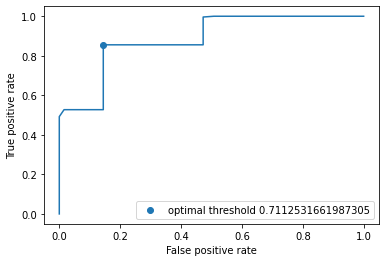

In [11]:
predictions = predict(params_max)
print("Predictions of globally optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [12]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of globally optimised NN with optimal threshold: {accuracy}")

accuracy of globally optimised NN with optimal threshold: 0.853515625


Predictions of BFGS optimised NN:
0: [1. 1. 1. 1. 1. 1. 1. 1. 1.] -> [ True] | pred: 0.49998074769973755
1: [1. 1. 1. 1. 1. 1. 1. 1. 0.] -> [False] | pred: 0.4999812841415405
2: [1. 1. 1. 1. 1. 1. 1. 0. 1.] -> [False] | pred: 0.49998265504837036
3: [1. 1. 1. 1. 1. 1. 1. 0. 0.] -> [ True] | pred: 0.4999848008155823
4: [1. 1. 1. 1. 1. 1. 0. 1. 1.] -> [False] | pred: 0.4999814033508301
5: [1. 1. 1. 1. 1. 1. 0. 1. 0.] -> [ True] | pred: 0.49998247623443604
6: [1. 1. 1. 1. 1. 1. 0. 0. 1.] -> [ True] | pred: 0.49998539686203003
7: [1. 1. 1. 1. 1. 1. 0. 0. 0.] -> [False] | pred: 0.49998998641967773
8: [1. 1. 1. 1. 1. 0. 1. 1. 1.] -> [False] | pred: 0.4999808073043823
9: [1. 1. 1. 1. 1. 0. 1. 1. 0.] -> [ True] | pred: 0.4999813437461853
10: [1. 1. 1. 1. 1. 0. 1. 0. 1.] -> [ True] | pred: 0.49998289346694946
11: [1. 1. 1. 1. 1. 0. 1. 0. 0.] -> [False] | pred: 0.4999851584434509
12: [1. 1. 1. 1. 1. 0. 0. 1. 1.] -> [ True] | pred: 0.49998152256011963
13: [1. 1. 1. 1. 1. 0. 0. 1. 0.] -> [False] | 

166: [1. 0. 1. 0. 1. 1. 0. 0. 1.] -> [ True] | pred: 0.5000566244125366
167: [1. 0. 1. 0. 1. 1. 0. 0. 0.] -> [False] | pred: 0.5001237392425537
168: [1. 0. 1. 0. 1. 0. 1. 1. 1.] -> [False] | pred: 0.4999889135360718
169: [1. 0. 1. 0. 1. 0. 1. 1. 0.] -> [ True] | pred: 0.499992311000824
170: [1. 0. 1. 0. 1. 0. 1. 0. 1.] -> [ True] | pred: 0.5000184178352356
171: [1. 0. 1. 0. 1. 0. 1. 0. 0.] -> [False] | pred: 0.5000398755073547
172: [1. 0. 1. 0. 1. 0. 0. 1. 1.] -> [ True] | pred: 0.4999988079071045
173: [1. 0. 1. 0. 1. 0. 0. 1. 0.] -> [False] | pred: 0.5000065565109253
174: [1. 0. 1. 0. 1. 0. 0. 0. 1.] -> [False] | pred: 0.500062108039856
175: [1. 0. 1. 0. 1. 0. 0. 0. 0.] -> [ True] | pred: 0.5001099109649658
176: [1. 0. 1. 0. 0. 1. 1. 1. 1.] -> [False] | pred: 0.5000048279762268
177: [1. 0. 1. 0. 0. 1. 1. 1. 0.] -> [ True] | pred: 0.500025749206543
178: [1. 0. 1. 0. 0. 1. 1. 0. 1.] -> [ True] | pred: 0.5000869631767273
179: [1. 0. 1. 0. 0. 1. 1. 0. 0.] -> [False] | pred: 0.500178813934

340: [0. 1. 0. 1. 0. 1. 0. 1. 1.] -> [ True] | pred: 0.5000379085540771
341: [0. 1. 0. 1. 0. 1. 0. 1. 0.] -> [False] | pred: 0.5000885128974915
342: [0. 1. 0. 1. 0. 1. 0. 0. 1.] -> [False] | pred: 0.5002323985099792
343: [0. 1. 0. 1. 0. 1. 0. 0. 0.] -> [ True] | pred: 0.5004648566246033
344: [0. 1. 0. 1. 0. 0. 1. 1. 1.] -> [ True] | pred: 0.500006914138794
345: [0. 1. 0. 1. 0. 0. 1. 1. 0.] -> [False] | pred: 0.49999797344207764
346: [0. 1. 0. 1. 0. 0. 1. 0. 1.] -> [False] | pred: 0.5001004338264465
347: [0. 1. 0. 1. 0. 0. 1. 0. 0.] -> [ True] | pred: 0.5001131296157837
348: [0. 1. 0. 1. 0. 0. 0. 1. 1.] -> [False] | pred: 0.5000377297401428
349: [0. 1. 0. 1. 0. 0. 0. 1. 0.] -> [ True] | pred: 0.5000228881835938
350: [0. 1. 0. 1. 0. 0. 0. 0. 1.] -> [ True] | pred: 0.5002420544624329
351: [0. 1. 0. 1. 0. 0. 0. 0. 0.] -> [False] | pred: 0.5003044605255127
352: [0. 1. 0. 0. 1. 1. 1. 1. 1.] -> [False] | pred: 0.5000049471855164
353: [0. 1. 0. 0. 1. 1. 1. 1. 0.] -> [ True] | pred: 0.500026464

505: [0. 0. 0. 0. 0. 0. 1. 1. 0.] -> [False] | pred: 0.49422234296798706
506: [0. 0. 0. 0. 0. 0. 1. 0. 1.] -> [False] | pred: 0.5003692507743835
507: [0. 0. 0. 0. 0. 0. 1. 0. 0.] -> [ True] | pred: 0.48468902707099915
508: [0. 0. 0. 0. 0. 0. 0. 1. 1.] -> [False] | pred: 0.49985530972480774
509: [0. 0. 0. 0. 0. 0. 0. 1. 0.] -> [ True] | pred: 0.4883840084075928
510: [0. 0. 0. 0. 0. 0. 0. 0. 1.] -> [ True] | pred: 0.5011835694313049
511: [0. 0. 0. 0. 0. 0. 0. 0. 0.] -> [False] | pred: 0.47106167674064636


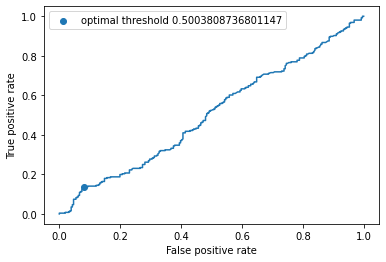

In [13]:
predictions = predict(params_bfgs_max)
print("Predictions of BFGS optimised NN:")
for i in range(len(y)):
    print(f"{i}: {x[i]} -> {y[i]} | pred: {predictions[i]}")

fpr, tpr, thresholds = roc_curve(y_true=y[:,0],y_score=predictions, pos_label=1)
metric = jnp.abs(1-tpr) + jnp.abs(fpr)
idx = plt.argmin(metric)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.scatter(fpr[idx], tpr[idx], label=f'optimal threshold {thresholds[idx]}')
plt.legend()
plt.show()

In [14]:
optimal_thresh = thresholds[idx]
classifications = (predictions > optimal_thresh)
accuracy = jnp.mean(classifications == y[:,0])
print(f"accuracy of BFGS optimised NN with optimal threshold: {accuracy}")

accuracy of BFGS optimised NN with optimal threshold: 0.525390625
